### 9.6.2 把CNN和RNN融合一起
数据集使用CIFAR10，数据集的加载及预处理请参考第3章，或本书代码及数据部分。  
把CNN和RNN简单组合在一起。

## 1.导入模块

In [1]:
import os
import math
import numpy as np
import pickle as p
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

## 2.定义加载函数

In [2]:
def load_CIFAR_data(data_dir):
    """导入CIFAR数据集"""
 
    images_train=[]
    labels_train=[]
    for i in range(5):
        f=os.path.join(data_dir,'data_batch_%d' % (i+1))
        print('loading ',f)
        # 调用 load_CIFAR_batch( )获得批量的图像及其对应的标签
        image_batch,label_batch=load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain=np.concatenate(images_train)
        Ytrain=np.concatenate(labels_train)
        del image_batch ,label_batch
    
    Xtest,Ytest=load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('finished loadding CIFAR-10 data')
    
    # 返回训练集的图像和标签，测试集的图像和标签
    return (Xtrain,Ytrain),(Xtest,Ytest)

## 3.定义批量加载函数

In [3]:
def load_CIFAR_batch(filename):
    """ 批量加载数据集 """  
    with open(filename, 'rb')as f:
        data_dict = p.load(f, encoding='bytes')
        images= data_dict[b'data']
        labels = data_dict[b'labels']
                
        # 把原始数据结构调整为: BCWH
        images = images.reshape(10000, 3, 32, 32)
        # tensorflow处理图像数据的结构：BWHC
        # 把通道数据C移动到最后一个维度
        images = images.transpose (0,2,3,1)
     
        labels = np.array(labels)
        
        return images, labels

## 4.运行加载函数

In [4]:
data_dir = r'..\data\cifar-10-batches-py'
(x_train,y_train),(x_test,y_test) = load_CIFAR_data(data_dir)

loading  ..\data\cifar-10-batches-py\data_batch_1
loading  ..\data\cifar-10-batches-py\data_batch_2
loading  ..\data\cifar-10-batches-py\data_batch_3
loading  ..\data\cifar-10-batches-py\data_batch_4
loading  ..\data\cifar-10-batches-py\data_batch_5
finished loadding CIFAR-10 data


## 5.可视化加载数据

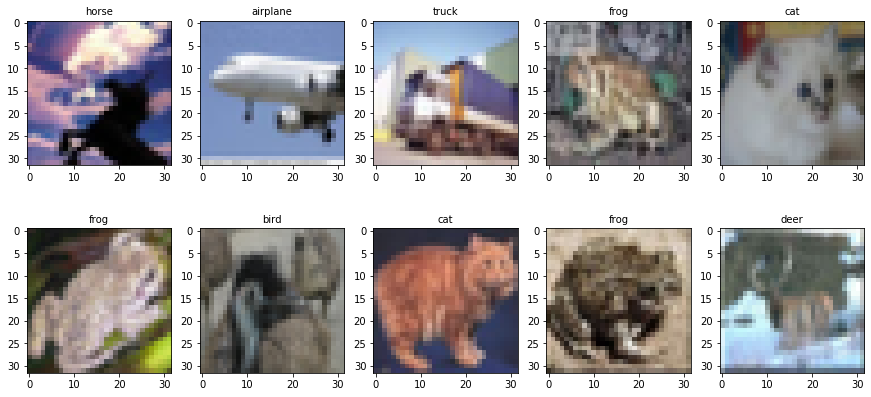

In [5]:
label_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer",
              5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}


def plot_images_labels(images, labels, num):
    total = len(images)
    fig = plt.gcf()
    fig.set_size_inches(15, math.ceil(num / 10) * 7)
    for i in range(0, num):
        choose_n = np.random.randint(0, total)
        
        ax = plt.subplot(math.ceil(num / 5), 5, 1 + i)
        ax.imshow(images[choose_n], cmap='binary')
        title = label_dict[labels[choose_n]]
        ax.set_title(title, fontsize=10)        
    plt.show()
    
plot_images_labels(x_train, y_train, 10)

## 6.对数据进行预处理

In [6]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [7]:
print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)

(50000, 32, 32, 3)   (50000, 10)
(10000, 32, 32, 3)   (10000, 10)


## 6.构建简单的cnn-rnn结构

In [8]:
from tensorflow.keras import layers
model = keras.Sequential()

In [9]:
x_shape = x_train.shape
model.add(layers.Conv2D(input_shape=(x_shape[1], x_shape[2], x_shape[3]),
                       filters=32, kernel_size=(3,3), strides=(1,1), 
                       padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

In [10]:
model.add(layers.Reshape(target_shape=(16*16, 32)))
model.add(layers.LSTM(50, return_sequences=False))

model.add(layers.Dense(10, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 18,006
Trainable params: 18,006
Non-trainable params: 0
_________________________________________________________________


## 编译模型

In [12]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

## 训练模型

In [13]:
history = model.fit(x_train, y_train, batch_size=32,epochs=5, validation_split=0.1)

Epoch 1/5
1407/1407 [==============================] - 25s 13ms/step - loss: 2.2268 - accuracy: 0.1602 - val_loss: 2.1612 - val_accuracy: 0.2002
Epoch 2/5
1407/1407 [==============================] - 17s 12ms/step - loss: 2.1044 - accuracy: 0.2094 - val_loss: 1.9284 - val_accuracy: 0.2674
Epoch 3/5
1407/1407 [==============================] - 17s 12ms/step - loss: 1.9077 - accuracy: 0.2722 - val_loss: 1.7991 - val_accuracy: 0.3386
Epoch 4/5
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7569 - accuracy: 0.3334 - val_loss: 1.6239 - val_accuracy: 0.3902
Epoch 5/5
1407/1407 [==============================] - 17s 12ms/step - loss: 1.6370 - accuracy: 0.3833 - val_loss: 1.5462 - val_accuracy: 0.4108


## 可视化运行结果

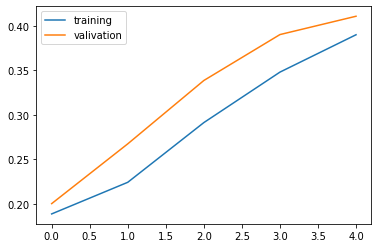

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'valivation'], loc='upper left')
plt.show()

## 测试模型

In [15]:
res = model.evaluate(x_test,y_test)

313/313 [==============================] - 2s 7ms/step - loss: 1.5562 - accuracy: 0.4084


## 把CNN和LSTM融合在一起

In [16]:
x_shape = x_train.shape
inn = layers.Input(shape=(x_shape[1], x_shape[2], x_shape[3]))
conv = layers.Conv2D(filters=32,kernel_size=(3,3), strides=(1,1),
                    padding='same', activation='relu')(inn)
pool = layers.MaxPool2D(pool_size=(2,2), padding='same')(conv)
flat = layers.Flatten()(pool)
dense1 = layers.Dense(64)(flat)

In [17]:
reshape = layers.Reshape(target_shape=(x_shape[1]*x_shape[2], x_shape[3]))(inn)
lstm_layer = layers.LSTM(32, return_sequences=False)(reshape)
dense2 = layers.Dense(64)(lstm_layer)

In [18]:
merged_layer = layers.concatenate([dense1, dense2])
outt = layers.Dense(10,activation='softmax')(merged_layer)
model01 = keras.Model(inputs=inn, outputs=outt)
model01.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model01.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1024, 3)      0           input_1[0][0]                    
______________________________________________________________________________________________

## 训练模型

In [19]:
history2 = model01.fit(x_train, y_train, batch_size=64,epochs=5, validation_split=0.1)

Epoch 1/5
704/704 [==============================] - 26s 35ms/step - loss: 1.7703 - accuracy: 0.3856 - val_loss: 1.2700 - val_accuracy: 0.5540
Epoch 2/5
704/704 [==============================] - 24s 34ms/step - loss: 1.2193 - accuracy: 0.5791 - val_loss: 1.2087 - val_accuracy: 0.5768
Epoch 3/5
704/704 [==============================] - 24s 34ms/step - loss: 1.1115 - accuracy: 0.6121 - val_loss: 1.1516 - val_accuracy: 0.6024
Epoch 4/5
704/704 [==============================] - 24s 34ms/step - loss: 1.0187 - accuracy: 0.6465 - val_loss: 1.0546 - val_accuracy: 0.6372
Epoch 5/5
704/704 [==============================] - 24s 34ms/step - loss: 0.9398 - accuracy: 0.6750 - val_loss: 1.0644 - val_accuracy: 0.6356


## 可视化运行结果

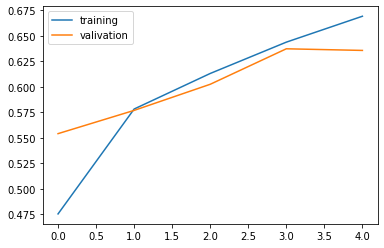

In [20]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training', 'valivation'], loc='upper left')
plt.show()